## Dataset annotation estraction 1

### Mask R-CNN dataset input format

#### In this project each object contained into one image must be passed to the network as an image in grey scale (one value for each pixel) where only one instance should be present in one mask image, obviusly can be more than one mask for each image, each mask should be associated with their class, with one array associated to the array of masks.



### Parsing of Supervisely dataset with annotations in mask format

#### This notebook shows how to convert the images in the supervisely dataset into the format required as input by the training program. In this notebook in detail is shown how to extract each instance(*) as a separate mask, following this steps:
- Import the image and its mask
- Separate the mask based on the class, obtaining one mask from each class present in the original mask.
- How to use the function cv2.connectedComponentsWithStats() for the separation of the istances of the same class.
- In the last part is shown how to pack this masks into one dict and group theme by class.
- The result of this job was printed into groups of plots relative to the same class.

#### NOTE: This notebook is only demonstrative, to explain how the separation of the instace into the masks is possible, but the dataset in this form isn't the best choice for Mask R-CNN. it is limeted beacause in the same pixel can't coexist more than one class, while Mask R-CNN can generate overlapped instance. For example take the disk in this example, it would have been better if the mask of the disk class had been intact, but as it is possible to see the presence of the instances of the other classes over the disk generate holes which can influence the effectiveness of the training of Mask R-CNN with this dataset, so this type of dataset is good for semantic segmentation but it's not so good for istance segmentation.

#### in the next notebook will be shown how to prepare the dataset starting from the json format of supervisely that is the better choise for training an instance segmentation model. 

*istance: object belonging at one class logicaly separable from other objects of the same class.


In [1]:
# import libraries
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import imutils
import math
import json
import cv2
import os

In [2]:
# definiscions of images and 
img_1_path = 'sample_imgs/cast_def_0_102.jpeg'
img_2_path = 'sample_imgs/cast_def_0_1427.jpeg'

mask_1_path = 'sample_masks/cast_def_0_102.png'
mask_2_path = 'sample_masks/cast_def_0_1427.png'

class_to_color_json = 'obj_class_to_machine_color.json'

text_settings = {
    'fontsize':22,
    'fontweight':10
}

#### In this section we load the original image with its mask, using matplot functions to hilight different classes into the mask not visible directly from human eye, due to the fact that each class differs from others only by a few points, more specificaly we have "disk" class corespondent to pixel values (4, 4, 4), while "hole" class corresponds to (3, 3, 3).
#### So below you can see 3 images, the first is the original image, the second is the mask image as is present in the dataset and the third is the same mask augmented by matplotlib to be distinguishable.

image shape: (512, 512, 3)
mask shape: (512, 512, 3)

splitted_mask shape: (512, 512)


(-0.5, 511.5, 511.5, -0.5)

<Figure size 432x288 with 0 Axes>

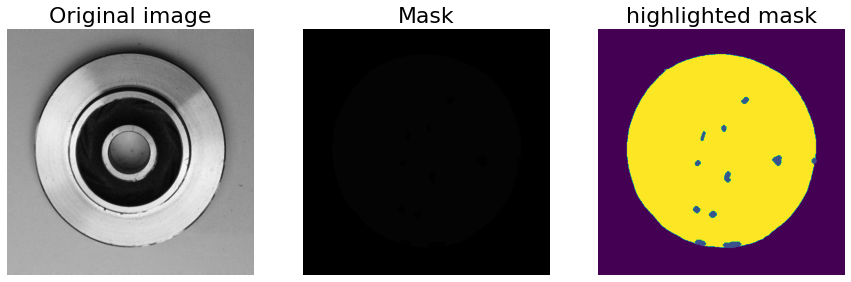

In [3]:
# loading images from their folders
img = cv2.imread(img_1_path)
mask = cv2.imread(mask_1_path)
print(f'image shape: {img.shape}')
print(f'mask shape: {mask.shape}\n')

#new_size = (512, 300)
#mask = cv2.resize(mask, new_size, interpolation = cv2.INTER_NEAREST)

# extracting one chanel from the mask image
# note that each channel is equal to the others
splitted_mask = cv2.split(mask)[0]
print(f'splitted_mask shape: {splitted_mask.shape}')

#----------------------------------------------------------------------------------------------------------
# plot functions ------------------------------------------------------------------------------------------
# note that the last image is augmented by matplotlib to make classes distingushable
plt.figure()

f, window = plt.subplots(1,3,figsize=(15,5)) 
f.patch.set_facecolor('#FFFFFF')

window[0].imshow(img)
window[0].set_title("Original image", fontdict = text_settings)
window[0].axis('off')

window[1].imshow(mask, cmap='gray')
window[1].set_title("Mask", fontdict = text_settings)
window[1].axis('off')

window[2].imshow(splitted_mask)
window[2].set_title("highlighted mask", fontdict = text_settings)
window[2].axis('off')

### Class-based bitmap separation
#### In this section the mask is divided into separate masks each one take only bitmaps belonging to one class, this is possible using inRange() function of openCV library which given an image in gray scale 

<Figure size 432x288 with 0 Axes>

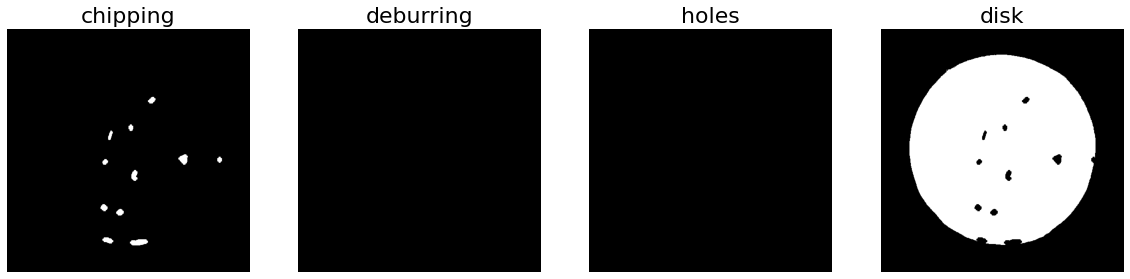

In [4]:
# if the above scripts has been runned we can proced to extract each feature
# the first step was to extract each class

with open (class_to_color_json, "r") as jsonFile:
    jsonString = jsonFile.read()

class2color = json.loads(jsonString)

class_names = [key for key in class2color.keys()]
class_masks = {}

# 
for i in range(len(class_names)):
    #print(class_names[i])
    #print(class2color[class_names[i]][0])
    class_masks[i] = cv2.inRange(splitted_mask, class2color[class_names[i]][0], class2color[class_names[i]][0])


#----------------------------------------------------------------------------------------------------------
# plot functions ------------------------------------------------------------------------------------------
cols = 5 if len(class_names) >= 5 else len(class_names)
rows = int((len(class_names)/cols) + 0.5)

#print(f'rows:{rows}, cols:{cols}')
plt.figure()
f, window = plt.subplots(rows, cols,figsize=(20,5)) 
f.patch.set_facecolor('#FFFFFF')

for i in range(len(class_names)):
    window[i].imshow(class_masks[i], cmap='gray')
    window[i].set_title(class_names[i], fontdict = text_settings)
    window[i].axis('off')

### Instance-based bitmap sepration

#### In this section we make the masks suitable for Mask R-CNN training, for this purpose we need to separate each single object that will be placed into a separate mask.



number of regions detected: 12
lables:
shape (512, 512)
lables identifiers [ 0  1  2  3  4  5  6  7  8  9 10 11]


number of regions detected: 1
lables:
shape (512, 512)
lables identifiers [0]


number of regions detected: 1
lables:
shape (512, 512)
lables identifiers [0]


number of regions detected: 3
lables:
shape (512, 512)
lables identifiers [0 1 2]


<Figure size 432x288 with 0 Axes>

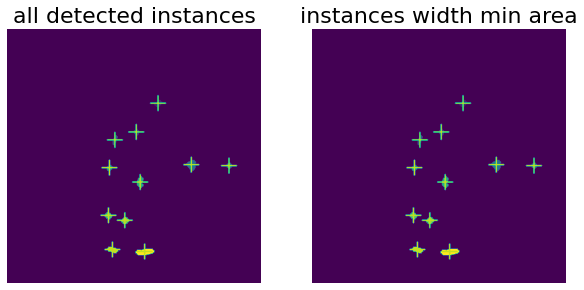

<Figure size 432x288 with 0 Axes>

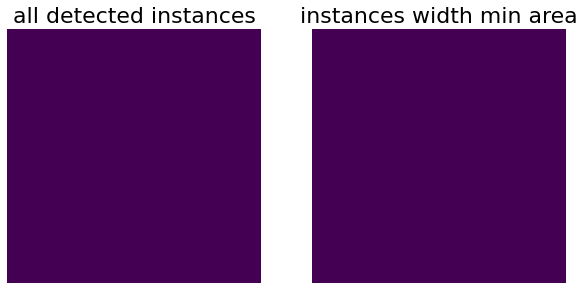

<Figure size 432x288 with 0 Axes>

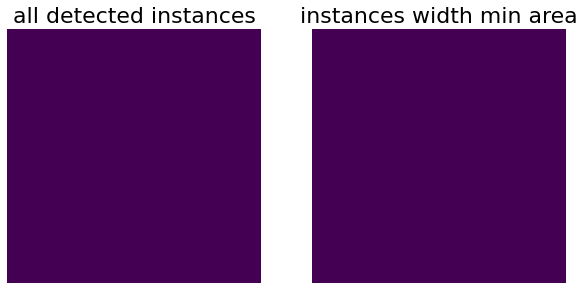

<Figure size 432x288 with 0 Axes>

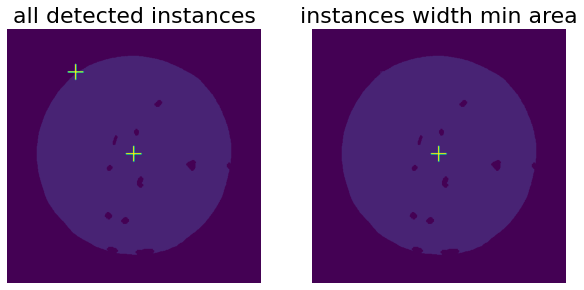

In [5]:
instances_class_masks = []
MIN_AREA = 50

for i in range(len(class_masks)):
    #extractions of each digunted bitmap

    n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(class_masks[i], connectivity = 8)

    '''
    notes about connectedComponentsWithStats():
    - input: 
        - ndarray (n, m) grey image
        
        - connectivity: int (?)

    -outputs:
        - n_labels:     int, number of object instaces detected

        - labels:       ndarray (n, m) grey image
                        in this image each object is marked with a different number (or label) on each pixel

        - stats:        list of vectors, there are one vector for each object in each object are mapped:
                        stats[object_idx][0] = The leftmost (x) coordinate which is the inclusive start of the bounding box in the horizontal direction.
                        stats[object_idx][1] = The topmost (y) coordinate which is the inclusive start of the bounding box in the vertical direction.
                        stats[object_idx][2] = The horizontal size of the bounding box.
                        stats[object_idx][3] = The vertical size of the bounding box.
                        stats[object_idx][4] = The total area (in pixels) of the connected component.

        - centroids:    list of vectors, there are one vector for each object in each object are mapped:
                        centroids[object_idx][0] = the x coordinate of the center of the object
                        centroids[object_idx][1] = the y coordinate of the center of the object
    '''
    
    instances_class_masks.append({
        "n_labels":     n_labels,
        "labels":       labels,
        "stats":        stats,
        "centroids":    centroids,
        "obj_class":    f'{i+1}'    
    })


    #----------------------------------------------------------------------------------------------------------
    # plot functions ------------------------------------------------------------------------------------------

    if instances_class_masks:
        # only for demonstration is printed out the result of the first image
        # each detected object are marked, and each object is filtered in base of its area
        # the algorithm can erroneously detect same pixel as an object appart so is appropriate
        # applay some filter.

        instances_class_mask_sample = instances_class_masks[i]

        n_labels    = instances_class_mask_sample['n_labels']
        labels      = instances_class_mask_sample['labels']
        stats       = instances_class_mask_sample['stats']
        centroids   = instances_class_mask_sample['centroids']

        # debug
        print(f'\n\nnumber of regions detected: {n_labels}')
        print('lables:')
        print(f'shape {labels.shape}')
        print(f'lables identifiers {np.unique(labels)}')

        lables_with_all_marker = labels.copy()
        lables_with_minarea_marker = labels.copy()

        for centroid, stat in zip(centroids[1:], stats[1:]):
            # first element skiped beacuse it's the background
            cv2.drawMarker(lables_with_all_marker, (int(centroid[0]), int(centroid[1])), color=(10), markerSize=30, thickness=2,                    markerType=cv2.MARKER_CROSS)
            if stat[4] > MIN_AREA:
                cv2.drawMarker(lables_with_minarea_marker, (int(centroid[0]), int(centroid[1])), color=(10), markerSize=30, thickness=2, markerType=cv2.MARKER_CROSS)


        plt.figure()
        f, window = plt.subplots(1, 2,figsize=(10,5)) 
        f.patch.set_facecolor('#FFFFFF')

        window[0].imshow(lables_with_all_marker)
        window[0].set_title('all detected instances', fontdict = text_settings)
        window[0].axis('off')

        window[1].imshow(lables_with_minarea_marker)
        window[1].set_title('instances width min area', fontdict = text_settings)
        window[1].axis('off')

<Figure size 432x288 with 0 Axes>

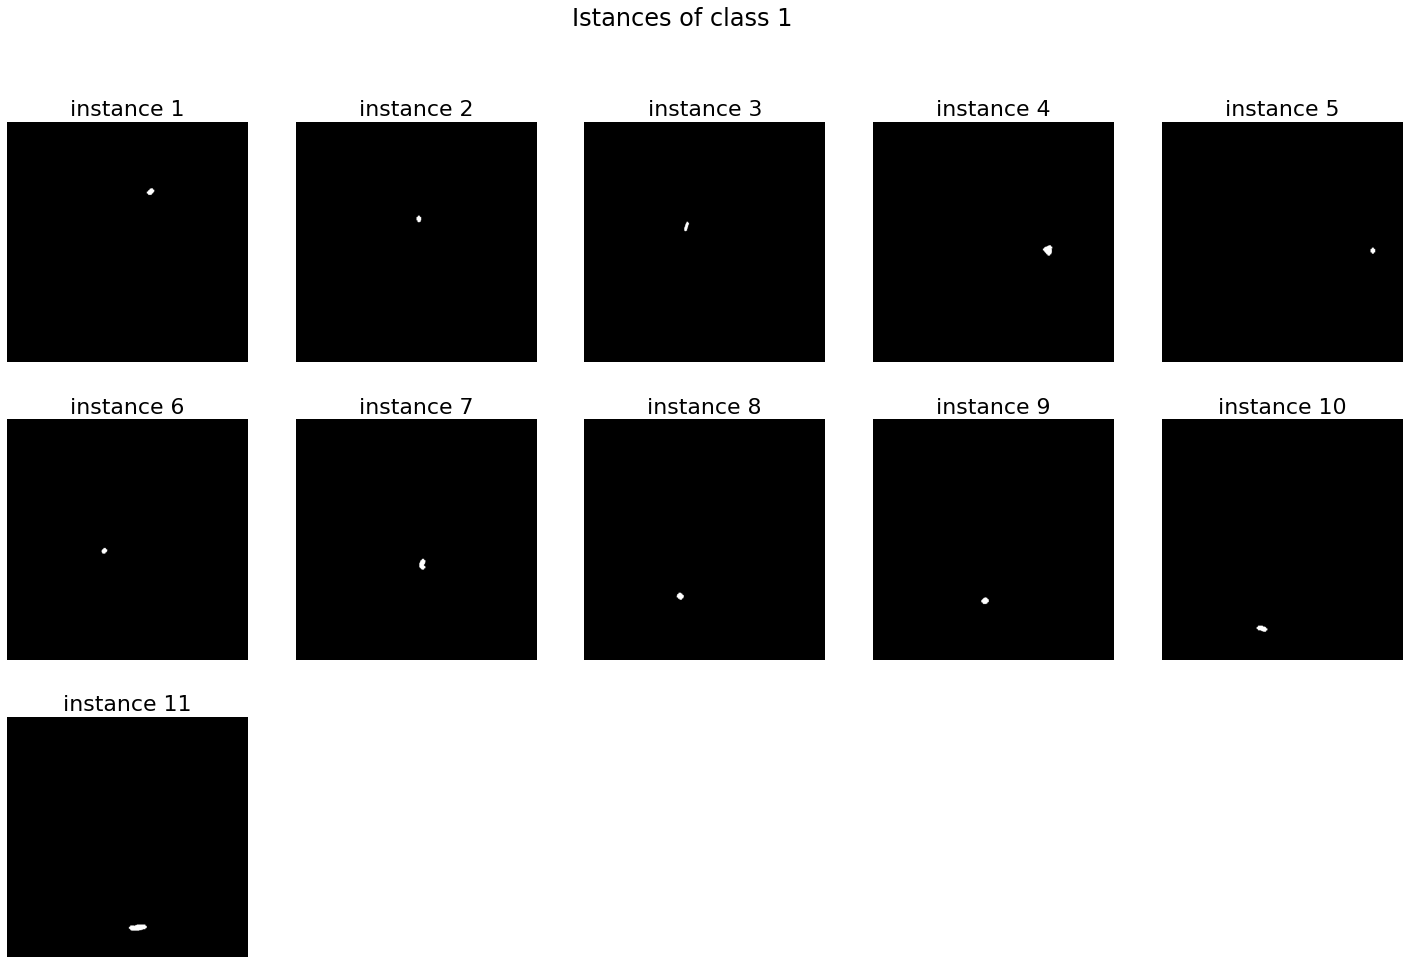

<Figure size 432x288 with 0 Axes>

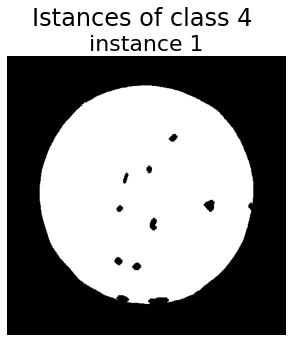

In [14]:
instaces_mask = {}
instance_idx = 0

#iterate over the list of masks
for instances in instances_class_masks:
    # for each bitmap will be created one separated mask
    
    # unpacking dict values
    (n_labels, labels, stats, centroids, obj_class) = instances.values()

    #print(f'num of lables: {n_labels}')
    for i in range(1, n_labels):
        # the first label is the background (!if it is the bigger object!)
        # for each label detected in the same mask
        
        if stats[i, 4] > MIN_AREA:
            # if the object is enough big
            # is created one mask for each istance
            
            if obj_class in instaces_mask:
                instaces_mask[obj_class].append(cv2.inRange(labels, i, i))
            else:
                instaces_mask[obj_class] = [cv2.inRange(labels, i, i)]

            instance_idx += 1

#print(instaces_mask.keys())

#----------------------------------------------------------------------------------------------------------
# plot functions ------------------------------------------------------------------------------------------
for class_key in instaces_mask.keys():
    # itera le classi di istanze
    n_instances = len(instaces_mask[class_key])

    #print(f'class: {i}')
    #print(f'num of instances: {n_instances}')
    
    if n_instances:
        
        cols = 5 if n_instances >= 5 else n_instances
        rows = math.ceil(n_instances/cols)

        #print(f'rows:{rows}, cols:{cols}')

        plt.figure()
        f, window = plt.subplots(rows, cols,figsize=(cols*5,(rows*5)+0.5)) 
        f.patch.set_facecolor('#FFFFFF')

        f.suptitle(f'Istances of class {class_key}', fontsize=24)

        for row in range(rows):
            for col in range(cols):
                j = row*cols + col
                if j < n_instances:
                    if rows > 1:
                        window[row][col].imshow(instaces_mask[class_key][j], cmap='gray')
                        window[row][col].set_title(f'instance {j+1}', fontdict = text_settings)
                    elif cols > 1:
                        window[col].imshow(instaces_mask[class_key][j], cmap='gray')
                        window[col].set_title(f'instance {j+1}', fontdict = text_settings)
                    else:
                        window.imshow(instaces_mask[class_key][j], cmap='gray')
                        window.set_title(f'instance {j+1}', fontdict = text_settings)
                if rows > 1:
                    window[row][col].axis('off')
                elif cols > 1:
                    window[col].axis('off')
                else:
                    window.axis('off')